In [2]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(colab_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])

average_mean_wind_speeds = scada_data[['dtTimeStamp','WindSpeedMean', 'intObjectId']].groupby('dtTimeStamp').median()[['WindSpeedMean']]
print(average_mean_wind_speeds)

                     WindSpeedMean
dtTimeStamp                       
2019-08-01 00:00:00            2.7
2019-08-01 00:10:00            2.9
2019-08-01 00:20:00            3.8
2019-08-01 00:30:00            4.3
2019-08-01 00:40:00            4.8
...                            ...
2019-09-30 23:20:00            7.0
2019-09-30 23:30:00            7.0
2019-09-30 23:40:00            6.9
2019-09-30 23:50:00            6.9
2019-10-01 00:00:00            6.8

[8785 rows x 1 columns]


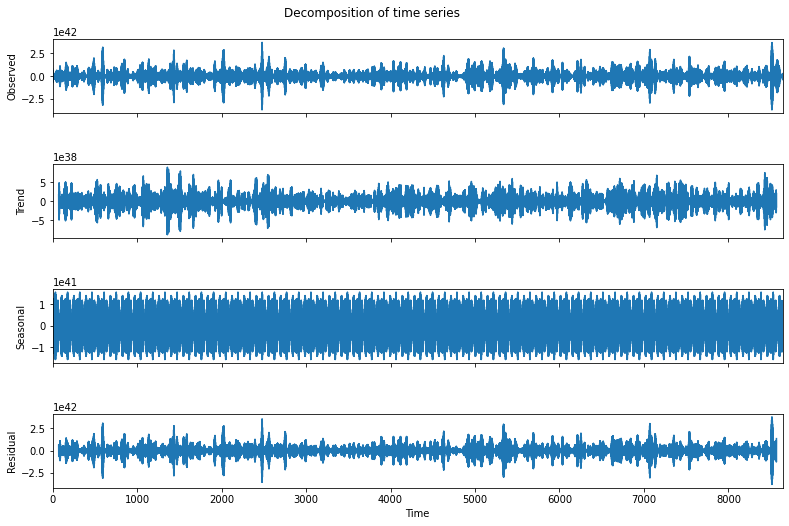

In [7]:
from scipy import signal

decomposition = sm.tsa.seasonal_decompose(np.diff(signal.detrend(average_mean_wind_speeds["WindSpeedMean"]), n=144), freq=int((24*60)/10))
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of time series')
plt.show()

Text(0.5, 1.0, 'Seasonal Component')

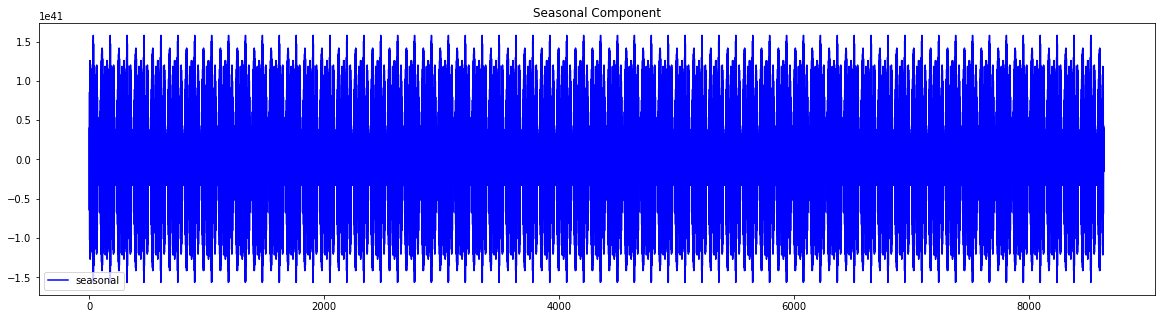

In [8]:
plt.figure(figsize=(20,5))
plt.plot(decomposition.seasonal, color='blue', label='seasonal')
plt.legend(loc='best')
plt.title('Seasonal Component')

# daily seasonality


Text(0.5, 1.0, 'Seasonal Component')

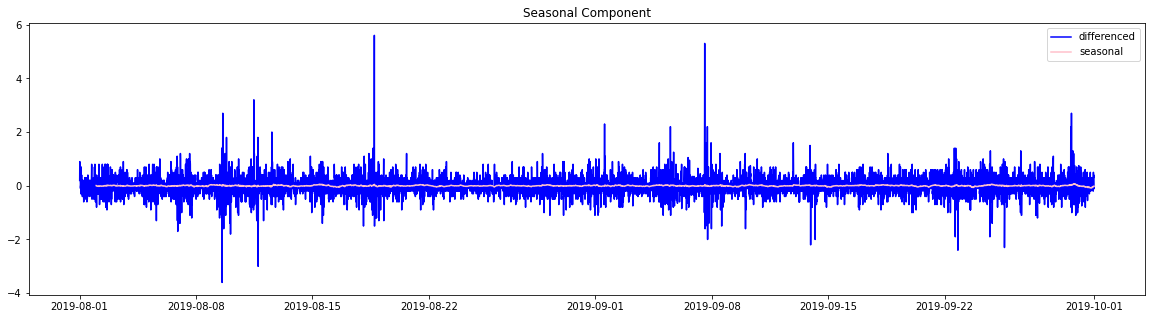

In [9]:
differenced = average_mean_wind_speeds.diff(1).dropna()

plt.figure(figsize=(20,5))
plt.plot(differenced, color='blue', label='differenced')
plt.plot(differenced.rolling(144).mean(), color='pink', label='seasonal')
plt.legend(loc='best')
plt.title('Seasonal Component')

In [ ]:
import pandas as pd
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose


stepwise_model = auto_arima(average_mean_wind_speeds[0:2001],
                            start_p=1, d=1, start_q=1,
                            max_p=3, max_d=1, max_q=3,
                            start_P=1, D=1, start_Q=1,
                            max_P=2, max_D=1, max_Q=2,
                            max_order=5, m=144,
                            seasonal=True, stationary=False,
                            information_criterion='aic',
                            alpha=0.05,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True,
                            n_jobs=-1,
                            maxiter=10)

In [30]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


X = average_mean_wind_speeds.values.flatten()
size = int(len(X) * 0.66)
train_data, test_data = X[0:size], X[size:len(X)]

differenced = np.diff(train_data, n=1)

history = [x for x in differenced]
predictions = [x for x in differenced]
for t in range(len(test_data)):
	model = ARIMA(differenced, order=(1,1,144))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

ValueError: ignored

In [ ]:
pred_dynamic = best_results.get_forecast(steps=144, alpha=0.05)
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
predicted = pred_dynamic.predicted_mean
truth = test_data['2019-08-09':].WindSpeedMean

print(predicted)
#print(truth)

2019-08-09 00:00:00    7.791591
2019-08-09 00:10:00    7.928154
2019-08-09 00:20:00    7.836811
2019-08-09 00:30:00    7.612735
2019-08-09 00:40:00    7.556360
                         ...   
2019-08-09 23:10:00    8.144871
2019-08-09 23:20:00    8.225584
2019-08-09 23:30:00    8.337589
2019-08-09 23:40:00    8.356322
2019-08-09 23:50:00    8.255925
Freq: 10T, Length: 144, dtype: float64


In [ ]:
mse = ((predicted - truth) ** 2).mean()
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))

The Mean Squared Error of our predictions is 2.5422


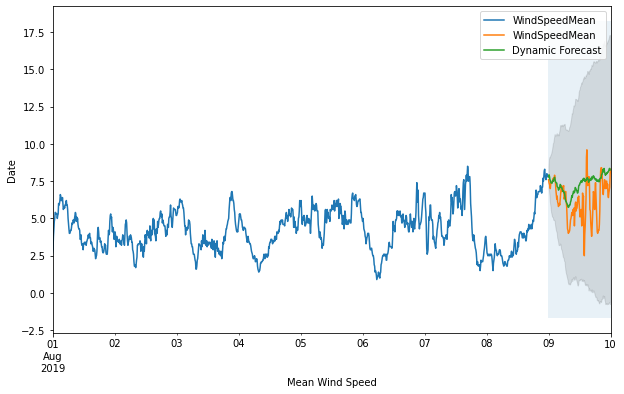

In [ ]:
# Plot the actual values.
axis_plt = train_data.plot(label='train data')
test_data[0:145].plot(ax=axis_plt, label='test data', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Dynamic Forecast')

# Plot confidence values and fill it with some colour.
axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('2019-09-15'), train_data.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Mean Wind Speed')
axis_plt.set_ylabel('Date')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')